# Sentiment Analysis Benchmarking

Benchmark three sentiment analysis approaches:
1. Rule-based: VADER
2. Traditional ML: TF-IDF + Logistic Regression
3. Deep Learning SOTA: RoBERTa


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from transformers import pipeline
import torch

def set_seed(seed: int = 42):
    import random
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\farza\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
reviews_df = pd.read_csv('./Reviews.csv')
sst_df = pd.read_csv(
    './training.1600000.processed.noemoticon.csv',
    names=['target','ids','date','flag','user','text'],
    encoding='latin-1'
)

sst_df = sst_df[sst_df.target.isin([0,4])].copy()
sst_df['sentiment'] = sst_df.target.map({0: 'negative', 4: 'positive'})

reviews_df = reviews_df[['Score','Text']].dropna()
reviews_df['sentiment'] = (
    reviews_df.Score
      .apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))
)
reviews_df = reviews_df[reviews_df.sentiment != 'neutral']

n_samples = 20000
n_sst = len(sst_df)
n_rev = len(reviews_df)
n_sst_sample = min(n_samples, n_sst)
n_rev_sample = min(n_samples, n_rev)

sst_sample = sst_df[['text','sentiment']].sample(
    n=n_sst_sample, random_state=42
)
reviews_sample = (
    reviews_df[['Text','sentiment']]
      .rename(columns={'Text':'text'})
      .sample(n=n_rev_sample, random_state=42)
)

data = pd.concat([sst_sample, reviews_sample], ignore_index=True)
X = data.text.values
y = data.sentiment.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Using {n_sst_sample} SST rows and {n_rev_sample} review rows; "
      f"total {len(data):,} examples.")


Using 10001 SST rows and 931 review rows; total 10,932 examples.


In [6]:
sid = SentimentIntensityAnalyzer()

def vader_predict(texts):
    preds = []
    for t in texts:
        score = sid.polarity_scores(t)['compound']
        preds.append('positive' if score >= 0 else 'negative')
    return preds

vader_preds = vader_predict(X_test)
print("VADER Accuracy:", accuracy_score(y_test, vader_preds))
print(classification_report(y_test, vader_preds))

VADER Accuracy: 0.6808413351623228
              precision    recall  f1-score   support

    negative       0.82      0.42      0.55      1031
    positive       0.64      0.92      0.75      1156

    accuracy                           0.68      2187
   macro avg       0.73      0.67      0.65      2187
weighted avg       0.72      0.68      0.66      2187



In [7]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)
ml_preds = clf.predict(X_test_tfidf)

print("ML Accuracy:", accuracy_score(y_test, ml_preds))
print(classification_report(y_test, ml_preds))

ML Accuracy: 0.7521719250114312
              precision    recall  f1-score   support

    negative       0.75      0.71      0.73      1031
    positive       0.75      0.79      0.77      1156

    accuracy                           0.75      2187
   macro avg       0.75      0.75      0.75      2187
weighted avg       0.75      0.75      0.75      2187



In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

device = 0 if torch.cuda.is_available() else -1

tokenizer = AutoTokenizer.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    use_fast=True
)
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment"
)

roberta = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
)

def roberta_predict(texts, batch_size=32):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        # ensure it's a Python list of strings
        if not isinstance(batch, list):
            batch = batch.tolist()

        # enforce truncation & padding
        results = roberta(
            batch,
            truncation=True,
            padding=True,
            max_length=512,
        )
        preds += [
            "positive" if r["label"].lower().startswith("positive") else "negative"
            for r in results
        ]
    return preds

X_test_list = X_test.tolist() if hasattr(X_test, "tolist") else list(X_test)
roberta_preds = roberta_predict(X_test_list)

print("RoBERTa Accuracy:", accuracy_score(y_test, roberta_preds))
print(classification_report(y_test, roberta_preds))


Device set to use cpu


RoBERTa Accuracy: 0.47142203932327387
              precision    recall  f1-score   support

    negative       0.47      1.00      0.64      1031
    positive       0.00      0.00      0.00      1156

    accuracy                           0.47      2187
   macro avg       0.24      0.50      0.32      2187
weighted avg       0.22      0.47      0.30      2187



C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

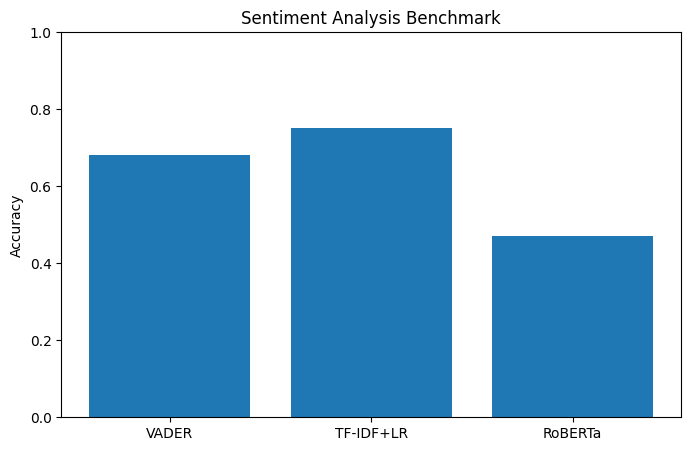

In [12]:
methods = ['VADER', 'TF-IDF+LR', 'RoBERTa']
scores = [
    accuracy_score(y_test, vader_preds),
    accuracy_score(y_test, ml_preds),
    accuracy_score(y_test, roberta_preds)
]

plt.figure(figsize=(8,5))
plt.bar(methods, scores)
plt.ylabel('Accuracy')
plt.title('Sentiment Analysis Benchmark')
plt.ylim(0, 1)
plt.show()